In [1]:
import geopandas as gpd
import descartes
import pandas as pd
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
import numpy as np
import contextily as ctx

Read in shapefiles for census tracts (`atx_ct`), elementary school catchments (`es_shp`), and 2015-16 [SABS survey](https://nces.ed.gov/programs/edge/SABS) (which lacks Burnet and Austin ISD):

In [3]:
data_dir = '../../data/'
atx_ct_shp = gpd.read_file(os.path.join(data_dir, '2020_texas_census_tracts/2020_texas_census_tracts.shp'))
es_shp = gpd.read_file(os.path.join(data_dir, 'aisd_shapefiles/20_21_elem_updt_v2.shp'))
sabs_shp = gpd.read_file(os.path.join(data_dir, 'SABS_1516_SchoolLevels/SABS_1516_Primary.shp'))

Filter out the other 49 states in SABS for the sake of memory and convenience:

In [4]:
sabs_shp = sabs_shp[sabs_shp['stAbbrev'] == 'TX']
sabs_shp.shape

(3719, 14)

Ensure coordinate reference systems (CRS) match. Census tract and AISD shapefiles use NAD83, and SABS is in Open Street Maps (OSM) CRS

In [5]:
print(atx_ct_shp.crs.name)
print(es_shp.crs.name)
print(sabs_shp.crs.name)

NAD83
NAD83
WGS 84 / Pseudo-Mercator


Let's convert to the OSM CRS:

In [6]:
atx_shp_osm = atx_ct_shp.to_crs({'init': 'EPSG:3857'})
es_shp_osm = es_shp.to_crs({'init': 'EPSG:3857'})
sabs_shp_osm = sabs_shp

/Users/TASethanho/anaconda3/envs/geopandas/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [7]:
assert atx_shp_osm.crs == es_shp_osm.crs == sabs_shp_osm.crs

### Visualize Shapefiles
Just to get an idea of what we're looking at. 

In [22]:
sabs_shp_osm.head()

,SrcName,ncessch,schnam,leaid,gslo,gshi,defacto,stAbbrev,openEnroll,Shape_Leng,Shape_Area,level,MultiBdy,geometry
36034,None,480000101145,CROSBYTON EL,4800001,PK,05,1,TX,0,231164.650104,1.768275e+09,1,0,"POLYGON ((-11281346.371 3987964.176, -11281343..."
36035,None,480000600274,ASPERMONT EL,4800006,PK,05,1,TX,0,246901.962200,3.005729e+09,1,0,"POLYGON ((-11189642.460 3898709.547, -11189638..."
36036,Dripping Springs,480000801507,DRIPPING SPRINGS EL,4800008,PK,05,0,TX,0,109636.791042,2.125308e+08,1,0,"MULTIPOLYGON (((-10922523.357 3551547.378, -10..."
36037,Walnut Springs,480000806989,WALNUT SPRINGS EL,4800008,PK,05,0,TX,0,159876.915178,4.116677e+08,1,0,"POLYGON ((-10926141.469 3546621.811, -10925182..."
36038,Rooster Springs,480000811280,ROOSTER SPRINGS EL,4800008,PK,05,0,TX,0,42288.398204,5.389171e+07,1,0,"POLYGON ((-10901471.558 3526669.331, -10901437..."


In [38]:
es_shp_osm.head()

,ISD,CAMPUS,SCHL_YEAR,ELEM_NAME,CAMPUS_ID,ALT_PK,geometry
0,AUSTIN ISD,ALLISON ELEM,2020-21,ALLISON,101,None,"POLYGON ((-10874723.564 3534720.499, -10874712..."
1,AUSTIN ISD,ANDREWS ELEM,2020-21,ANDREWS,102,None,"POLYGON ((-10873791.272 3544072.561, -10873793..."
2,AUSTIN ISD,BALDWIN ELEM,2020-21,BALDWIN,187,None,"MULTIPOLYGON (((-10900697.518 3540432.910, -10..."
3,AUSTIN ISD,BARANOFF ELEM,2020-21,BARANOFF,182,MENCHACA,"MULTIPOLYGON (((-10895217.316 3526843.651, -10..."
4,AUSTIN ISD,BARRINGTON ELEM,2020-21,BARRINGTON,149,None,"POLYGON ((-10874594.131 3549678.828, -10874585..."


In [40]:
atx_shp_osm.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,48,189,950200,48189950200,9502,Census Tract 9502,G5020,S,6306913.0,0.0,+34.2117433,-101.7172438,"POLYGON ((-11325148.156 4057103.568, -11325147..."
1,48,219,950400,48219950400,9504,Census Tract 9504,G5020,S,12691656.0,5302.0,+33.5889072,-102.3953070,"POLYGON ((-11400914.838 3971200.876, -11400914..."
2,48,219,950300,48219950300,9503,Census Tract 9503,G5020,S,12186639.0,0.0,+33.5869355,-102.3416971,"POLYGON ((-11395512.062 3973076.810, -11395512..."
3,48,219,950100,48219950100,9501,Census Tract 9501,G5020,S,214157569.0,0.0,+33.7715552,-102.1822653,"POLYGON ((-11385971.861 3991815.397, -11385969..."
4,48,219,950600,48219950600,9506,Census Tract 9506,G5020,S,358638163.0,0.0,+33.4659916,-102.1861385,"POLYGON ((-11390017.136 3949860.960, -11389762..."


<AxesSubplot:>

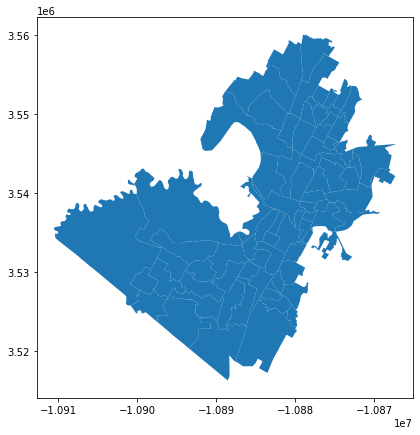

In [6]:
es_shp_osm.plot(figsize=(10, 7))

Calculate the area within each polygon:

In [7]:
es_shp_osm['es_area'] = es_shp_osm.area
atx_shp_osm['cbg_area'] = atx_shp_osm.area

Overlay the two polygons:

In [8]:
es_atx = gpd.overlay(atx_shp_osm, es_shp_osm, how='intersection')

Calculate overlap area and percent overlap:

In [9]:
es_atx['overlap_area'] = es_atx.area
# what percent of an elementary catchment corresponds to the underlying CBG?
es_atx['pct_overlap'] = (es_atx['overlap_area'] / es_atx['cbg_area']) * 100

Grab only the columns of interest to save as a CSV (this will ultimately be further transformed into something like `travel.csv` from the toy contact partitioning model):

In [10]:
overlaps = es_atx[['GEOID', 'ISD', 'CAMPUS', 'SCHL_YEAR', 'pct_overlap']]

Add an age level indicator column:

In [11]:
overlaps['level'] = 'elementary'

<ipython-input-11-e32dde511769>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overlaps['level'] = 'elementary'


Write to file:

In [12]:
overlaps.to_csv('AISD_elem_census_tract_overlaps.csv')